In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

from ViT import ViT

In [2]:
# Training settings
batch_size = 512
epochs = 100
lr = 3e-5
gamma = 0.7
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [4]:
os.makedirs('data', exist_ok=True)
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test1.zip') as test_zip:
    test_zip.extractall('data')

In [5]:
train_dir = 'data/train'
test_dir = 'data/test'
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

Train Data: 25000
Test Data: 12500


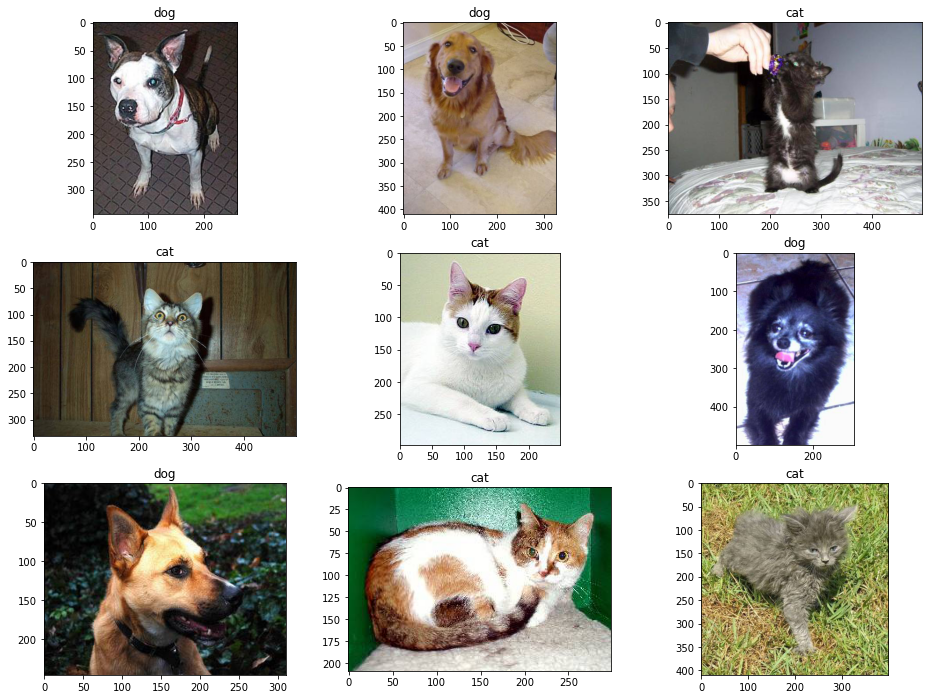

In [6]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [7]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [8]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [9]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

In [10]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

20000 40
5000 10


In [11]:
model = ViT(image_size=224, 
            patch_size=32, 
            num_classes=2, 
            dim=128, 
            depth=12, 
            heads=8, 
            mlp_dim=3072, ##? 
            pool = 'cls', 
            channels= 3, 
            dim_head=64, 
            dropout=0., 
            emb_dropout=0.).to(device)

In [12]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [13]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    model.train()

    pbar = tqdm(train_loader)
    for idx, (data, label) in enumerate(pbar):
        data = data.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={idx}')

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

loss=0.6979550719261169 batch_id=39: 100%|██████| 40/40 [02:03<00:00,  3.10s/it]


Epoch : 1 - loss : 0.7190 - acc: 0.4981 - val_loss : 0.6935 - val_acc: 0.5005



loss=0.6899972558021545 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 2 - loss : 0.6924 - acc: 0.5157 - val_loss : 0.6924 - val_acc: 0.5240



loss=0.7144470810890198 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.07s/it]


Epoch : 3 - loss : 0.6926 - acc: 0.5154 - val_loss : 0.6910 - val_acc: 0.5293



loss=0.6936721801757812 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.07s/it]


Epoch : 4 - loss : 0.6918 - acc: 0.5231 - val_loss : 0.6901 - val_acc: 0.5212



loss=0.6741665601730347 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.07s/it]


Epoch : 5 - loss : 0.6903 - acc: 0.5255 - val_loss : 0.6959 - val_acc: 0.5141



loss=0.7152450084686279 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 6 - loss : 0.6885 - acc: 0.5389 - val_loss : 0.6888 - val_acc: 0.5094



loss=0.69264817237854 batch_id=39: 100%|████████| 40/40 [02:01<00:00,  3.05s/it]


Epoch : 7 - loss : 0.6862 - acc: 0.5446 - val_loss : 0.6788 - val_acc: 0.5754



loss=0.6747308373451233 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 8 - loss : 0.6795 - acc: 0.5634 - val_loss : 0.6759 - val_acc: 0.5760



loss=0.7287082076072693 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.05s/it]


Epoch : 9 - loss : 0.6796 - acc: 0.5660 - val_loss : 0.6800 - val_acc: 0.5620



loss=0.6658778786659241 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.05s/it]


Epoch : 10 - loss : 0.6772 - acc: 0.5645 - val_loss : 0.6721 - val_acc: 0.5856



loss=0.7419640421867371 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 11 - loss : 0.6761 - acc: 0.5742 - val_loss : 0.6906 - val_acc: 0.5331



loss=0.6673524975776672 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 12 - loss : 0.6823 - acc: 0.5558 - val_loss : 0.6738 - val_acc: 0.5898



loss=0.6823684573173523 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 13 - loss : 0.6769 - acc: 0.5687 - val_loss : 0.6697 - val_acc: 0.5960



loss=0.6781995296478271 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 14 - loss : 0.6729 - acc: 0.5796 - val_loss : 0.6668 - val_acc: 0.5951



loss=0.7007461190223694 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 15 - loss : 0.6719 - acc: 0.5832 - val_loss : 0.6752 - val_acc: 0.5735



loss=0.6314665675163269 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 16 - loss : 0.6732 - acc: 0.5791 - val_loss : 0.6704 - val_acc: 0.5824



loss=0.7239446640014648 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 17 - loss : 0.6736 - acc: 0.5755 - val_loss : 0.6642 - val_acc: 0.5952



loss=0.6690217852592468 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 18 - loss : 0.6714 - acc: 0.5826 - val_loss : 0.6641 - val_acc: 0.5969



loss=0.654127299785614 batch_id=39: 100%|███████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 19 - loss : 0.6731 - acc: 0.5800 - val_loss : 0.6784 - val_acc: 0.5630



loss=0.6002882719039917 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 20 - loss : 0.6704 - acc: 0.5840 - val_loss : 0.6623 - val_acc: 0.5960



loss=0.6551669836044312 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 21 - loss : 0.6658 - acc: 0.5883 - val_loss : 0.6588 - val_acc: 0.6016



loss=0.5891598463058472 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 22 - loss : 0.6665 - acc: 0.5851 - val_loss : 0.6601 - val_acc: 0.6035



loss=0.6204563975334167 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 23 - loss : 0.6680 - acc: 0.5860 - val_loss : 0.6588 - val_acc: 0.5987



loss=0.6788188815116882 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 24 - loss : 0.6649 - acc: 0.5917 - val_loss : 0.6590 - val_acc: 0.6066



loss=0.6970497965812683 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.05s/it]


Epoch : 25 - loss : 0.6653 - acc: 0.5884 - val_loss : 0.6569 - val_acc: 0.6105



loss=0.6993067264556885 batch_id=39: 100%|██████| 40/40 [02:03<00:00,  3.09s/it]


Epoch : 26 - loss : 0.6627 - acc: 0.5937 - val_loss : 0.6493 - val_acc: 0.6091



loss=0.5511442422866821 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 27 - loss : 0.6543 - acc: 0.6002 - val_loss : 0.6444 - val_acc: 0.6178



loss=0.6719036102294922 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 28 - loss : 0.6541 - acc: 0.6039 - val_loss : 0.6565 - val_acc: 0.5979



loss=0.6303712725639343 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 29 - loss : 0.6475 - acc: 0.6122 - val_loss : 0.6507 - val_acc: 0.5956



loss=0.6630011796951294 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 30 - loss : 0.6505 - acc: 0.6089 - val_loss : 0.6297 - val_acc: 0.6487



loss=0.70645672082901 batch_id=39: 100%|████████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 31 - loss : 0.6403 - acc: 0.6236 - val_loss : 0.6180 - val_acc: 0.6578



loss=0.585381805896759 batch_id=39: 100%|███████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 32 - loss : 0.6344 - acc: 0.6354 - val_loss : 0.6337 - val_acc: 0.6267



loss=0.6460955142974854 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 33 - loss : 0.6296 - acc: 0.6438 - val_loss : 0.6111 - val_acc: 0.6637



loss=0.6953595876693726 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 34 - loss : 0.6343 - acc: 0.6346 - val_loss : 0.6600 - val_acc: 0.5906



loss=0.6334891319274902 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 35 - loss : 0.6300 - acc: 0.6381 - val_loss : 0.6311 - val_acc: 0.6353



loss=0.6453061103820801 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 36 - loss : 0.6378 - acc: 0.6309 - val_loss : 0.6288 - val_acc: 0.6269



loss=0.5524536371231079 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.07s/it]


Epoch : 37 - loss : 0.6217 - acc: 0.6505 - val_loss : 0.5964 - val_acc: 0.6745



loss=0.5893158316612244 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 38 - loss : 0.6166 - acc: 0.6557 - val_loss : 0.5960 - val_acc: 0.6834



loss=0.5697265863418579 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 39 - loss : 0.6140 - acc: 0.6567 - val_loss : 0.5845 - val_acc: 0.6872



loss=0.6046427488327026 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 40 - loss : 0.6089 - acc: 0.6642 - val_loss : 0.6136 - val_acc: 0.6559



loss=0.7213431596755981 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 41 - loss : 0.6125 - acc: 0.6573 - val_loss : 0.6215 - val_acc: 0.6476



loss=0.5829848647117615 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.05s/it]


Epoch : 42 - loss : 0.6104 - acc: 0.6629 - val_loss : 0.5892 - val_acc: 0.6819



loss=0.6007994413375854 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.05s/it]


Epoch : 43 - loss : 0.6020 - acc: 0.6674 - val_loss : 0.5741 - val_acc: 0.6991



loss=0.6719344258308411 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 44 - loss : 0.6012 - acc: 0.6677 - val_loss : 0.5693 - val_acc: 0.7042



loss=0.685369610786438 batch_id=39: 100%|███████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 45 - loss : 0.5984 - acc: 0.6679 - val_loss : 0.5752 - val_acc: 0.6915



loss=0.5678313374519348 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.05s/it]


Epoch : 46 - loss : 0.5924 - acc: 0.6734 - val_loss : 0.5645 - val_acc: 0.7029



loss=0.5827631950378418 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 47 - loss : 0.5878 - acc: 0.6804 - val_loss : 0.5688 - val_acc: 0.7097



loss=0.6152958273887634 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 48 - loss : 0.5956 - acc: 0.6735 - val_loss : 0.5557 - val_acc: 0.7155



loss=0.4484037756919861 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 49 - loss : 0.5821 - acc: 0.6844 - val_loss : 0.5558 - val_acc: 0.7120



loss=0.5681672096252441 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 50 - loss : 0.5862 - acc: 0.6807 - val_loss : 0.5501 - val_acc: 0.7168



loss=0.605445146560669 batch_id=39: 100%|███████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 51 - loss : 0.5824 - acc: 0.6876 - val_loss : 0.5508 - val_acc: 0.7148



loss=0.5051233768463135 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 52 - loss : 0.5783 - acc: 0.6898 - val_loss : 0.5557 - val_acc: 0.7128



loss=0.6292576193809509 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 53 - loss : 0.5807 - acc: 0.6817 - val_loss : 0.5483 - val_acc: 0.7209



loss=0.4032723009586334 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 54 - loss : 0.5747 - acc: 0.6955 - val_loss : 0.5425 - val_acc: 0.7207



loss=0.5544753670692444 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 55 - loss : 0.5774 - acc: 0.6882 - val_loss : 0.5392 - val_acc: 0.7268



loss=0.6003962755203247 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 56 - loss : 0.5746 - acc: 0.6923 - val_loss : 0.5430 - val_acc: 0.7208



loss=0.5854067206382751 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 57 - loss : 0.5756 - acc: 0.6953 - val_loss : 0.5433 - val_acc: 0.7194



loss=0.6170241236686707 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 58 - loss : 0.5767 - acc: 0.6914 - val_loss : 0.5432 - val_acc: 0.7251



loss=0.5361334681510925 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 59 - loss : 0.5740 - acc: 0.6942 - val_loss : 0.5487 - val_acc: 0.7167



loss=0.5842520594596863 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 60 - loss : 0.5720 - acc: 0.6999 - val_loss : 0.5434 - val_acc: 0.7219



loss=0.5062900185585022 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 61 - loss : 0.5719 - acc: 0.6945 - val_loss : 0.5366 - val_acc: 0.7285



loss=0.5391194224357605 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 62 - loss : 0.5635 - acc: 0.7024 - val_loss : 0.5702 - val_acc: 0.6961



loss=0.45227208733558655 batch_id=39: 100%|█████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 63 - loss : 0.5651 - acc: 0.7006 - val_loss : 0.5275 - val_acc: 0.7349



loss=0.501916766166687 batch_id=39: 100%|███████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 64 - loss : 0.5603 - acc: 0.7051 - val_loss : 0.5244 - val_acc: 0.7389



loss=0.6396830677986145 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 65 - loss : 0.5606 - acc: 0.7075 - val_loss : 0.5222 - val_acc: 0.7369



loss=0.6026379466056824 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 66 - loss : 0.5597 - acc: 0.7073 - val_loss : 0.5296 - val_acc: 0.7299



loss=0.44853243231773376 batch_id=39: 100%|█████| 40/40 [02:02<00:00,  3.07s/it]


Epoch : 67 - loss : 0.5602 - acc: 0.7094 - val_loss : 0.5265 - val_acc: 0.7305



loss=0.6291083097457886 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 68 - loss : 0.5587 - acc: 0.7084 - val_loss : 0.5139 - val_acc: 0.7437



loss=0.4947243332862854 batch_id=39: 100%|██████| 40/40 [02:03<00:00,  3.09s/it]


Epoch : 69 - loss : 0.5541 - acc: 0.7118 - val_loss : 0.5206 - val_acc: 0.7391



loss=0.6337078809738159 batch_id=39: 100%|██████| 40/40 [02:03<00:00,  3.08s/it]


Epoch : 70 - loss : 0.5576 - acc: 0.7100 - val_loss : 0.5140 - val_acc: 0.7468



loss=0.6027873754501343 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 71 - loss : 0.5537 - acc: 0.7176 - val_loss : 0.5150 - val_acc: 0.7423



loss=0.6103866100311279 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 72 - loss : 0.5601 - acc: 0.7035 - val_loss : 0.5187 - val_acc: 0.7395



loss=0.4659848213195801 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 73 - loss : 0.5506 - acc: 0.7192 - val_loss : 0.5145 - val_acc: 0.7455



loss=0.4436528980731964 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 74 - loss : 0.5460 - acc: 0.7185 - val_loss : 0.5091 - val_acc: 0.7446



loss=0.49904078245162964 batch_id=39: 100%|█████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 75 - loss : 0.5457 - acc: 0.7174 - val_loss : 0.5194 - val_acc: 0.7335



loss=0.4384303390979767 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 76 - loss : 0.5530 - acc: 0.7128 - val_loss : 0.5070 - val_acc: 0.7481



loss=0.49378523230552673 batch_id=39: 100%|█████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 77 - loss : 0.5448 - acc: 0.7212 - val_loss : 0.5073 - val_acc: 0.7482



loss=0.46711111068725586 batch_id=39: 100%|█████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 78 - loss : 0.5439 - acc: 0.7189 - val_loss : 0.5128 - val_acc: 0.7445



loss=0.49703386425971985 batch_id=39: 100%|█████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 79 - loss : 0.5438 - acc: 0.7191 - val_loss : 0.5020 - val_acc: 0.7503



loss=0.7463798522949219 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 80 - loss : 0.5521 - acc: 0.7137 - val_loss : 0.5058 - val_acc: 0.7516



loss=0.48338526487350464 batch_id=39: 100%|█████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 81 - loss : 0.5461 - acc: 0.7224 - val_loss : 0.5001 - val_acc: 0.7505



loss=0.4431282877922058 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 82 - loss : 0.5370 - acc: 0.7287 - val_loss : 0.5214 - val_acc: 0.7333



loss=0.5013566017150879 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.05s/it]


Epoch : 83 - loss : 0.5490 - acc: 0.7200 - val_loss : 0.5064 - val_acc: 0.7478



loss=0.4733423888683319 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 84 - loss : 0.5366 - acc: 0.7275 - val_loss : 0.5236 - val_acc: 0.7348



loss=0.46855393052101135 batch_id=39: 100%|█████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 85 - loss : 0.5412 - acc: 0.7242 - val_loss : 0.4955 - val_acc: 0.7635



loss=0.5513253808021545 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 86 - loss : 0.5413 - acc: 0.7242 - val_loss : 0.4948 - val_acc: 0.7558



loss=0.5633047819137573 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 87 - loss : 0.5341 - acc: 0.7288 - val_loss : 0.4894 - val_acc: 0.7535



loss=0.5463722944259644 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 88 - loss : 0.5383 - acc: 0.7271 - val_loss : 0.5012 - val_acc: 0.7480



loss=0.6346853971481323 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 89 - loss : 0.5483 - acc: 0.7168 - val_loss : 0.5303 - val_acc: 0.7247



loss=0.5081384181976318 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.06s/it]


Epoch : 90 - loss : 0.5332 - acc: 0.7260 - val_loss : 0.4884 - val_acc: 0.7620



loss=0.5999689698219299 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 91 - loss : 0.5373 - acc: 0.7210 - val_loss : 0.5093 - val_acc: 0.7430



loss=0.4231320321559906 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 92 - loss : 0.5281 - acc: 0.7319 - val_loss : 0.4929 - val_acc: 0.7586



loss=0.6773645877838135 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 93 - loss : 0.5299 - acc: 0.7279 - val_loss : 0.4864 - val_acc: 0.7611



loss=0.467500776052475 batch_id=39: 100%|███████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 94 - loss : 0.5274 - acc: 0.7348 - val_loss : 0.5169 - val_acc: 0.7360



loss=0.5844478011131287 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 95 - loss : 0.5343 - acc: 0.7276 - val_loss : 0.4841 - val_acc: 0.7665



loss=0.6162092089653015 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.04s/it]


Epoch : 96 - loss : 0.5311 - acc: 0.7275 - val_loss : 0.4863 - val_acc: 0.7670



loss=0.5052592158317566 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 97 - loss : 0.5244 - acc: 0.7375 - val_loss : 0.4784 - val_acc: 0.7657



loss=0.5642808675765991 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 98 - loss : 0.5264 - acc: 0.7361 - val_loss : 0.4890 - val_acc: 0.7562



loss=0.5662110447883606 batch_id=39: 100%|██████| 40/40 [02:01<00:00,  3.03s/it]


Epoch : 99 - loss : 0.5300 - acc: 0.7266 - val_loss : 0.4757 - val_acc: 0.7687



loss=0.5773449540138245 batch_id=39: 100%|██████| 40/40 [02:02<00:00,  3.07s/it]


Epoch : 100 - loss : 0.5247 - acc: 0.7362 - val_loss : 0.4779 - val_acc: 0.7667

